## TL;DR
As we increase model complexity, the model's performance (average loss on fresh data) almost always improves and the gets worse, meaning there is an optimal level of complexity. 

Models below that optimal level tend to do poorly on both training and test sets. Models above that level tend to do well on the training set and very badly on the test set.

## Overfitting
We have learned how to measure the performance of a particular model. Since we know about the bias (inflexibility) / variance (hair) tradeoff as models grow complex, what does out-of-sample perfomance look like as we increase complexity?

### Setup

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

df = pd.read_csv("data/noisysample.csv")
df.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [4]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]

#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30), train_size=24, test_size=6)

xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

In [5]:
from sklearn.preprocessing import PolynomialFeatures
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

degrees=range(21)
traintestlists=make_features(xtrain, xtest, degrees)

### An Example
You will recall that the big question in the Romney election model is: what order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting many different models (remember the fit is made by minimizing the empirical risk on the training set), each with increasing dimension `d`, and looking at the training-error and the test-error in each of these models. So we first try $\cal{H}_0$, then $\cal{H}_1$, then $\cal{H}_2$, and so on.

We calculate the `mean_squared_error` between the model's predictions and the data, BOTH on the training set and test set. We plot this error as a function of the defree of the polynomial `d`.

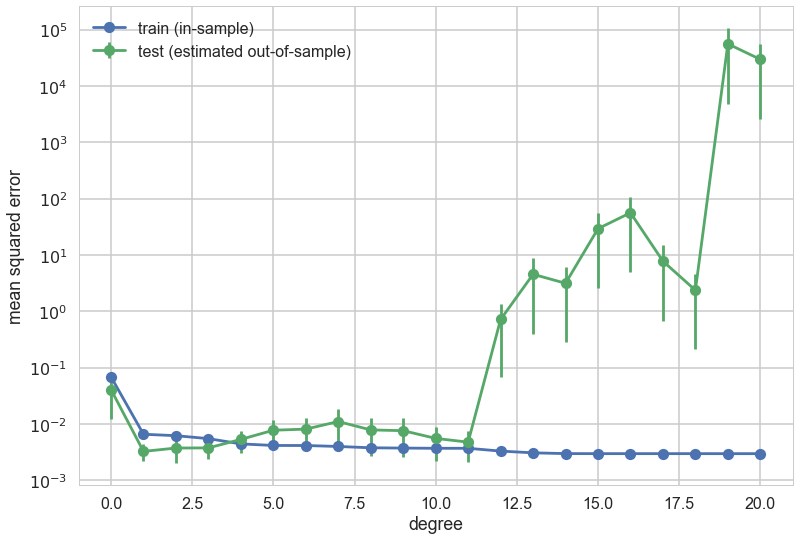

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(100)

error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))
error_bars=np.empty(len(degrees))
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    #fit
    #predict
    #calculate mean squared error
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)
    error_bars[d] = np.std((ytest-prediction_on_test)**2)/np.sqrt(len(prediction_on_test))
    
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.errorbar(degrees, error_test, yerr=error_bars, marker='o', label='test (estimated out-of-sample)')
#plt.plot(degrees, error_test, marker='o', label='test')
#plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

Despite the extremely imprecise estimates (only six points in the test set!), the graph shows a classic structure.

The training error decreases with increasing degree of the polynomial. This ought to make sense given what you know now: one can construct an arbitrarily complex polynomial to fit all the training data: indeed one could construct an order 24 polynomial which perfectly interpolates the 24 data points in the training set. You also know that this would do very badly on the test set as it would wiggle like mad to capture all the data points. And this is indeed what we see in the test set error. 

For extremely low degree polynomials like $d=0$ a flat line capturing the mean value of the data or $d=1$ a straight line fitting the data, the polynomial is not curvy enough to capturve the contours of the data. We are in the bias/deterministic error regime, where we will always have some difference between the data and the fit since the hypothesis is too simple. But, for degrees higher than 5 or so, the polynomial starts to wiggle too much to capture the training data. The test set error increases as the predictive power of the polynomial goes down thanks to the contortions it must endure to fit the training data.

Thus the model performance [estiamted via test set error] first decreases as the model get more expressive, and then, once we exceed a certain level of complexity (indexed by $d$ below), it increases. This idea can be used to identify just the right amount of complexity in the model by picking as **the best hypothesis as the one that minimizes out-of-sample error** or risk. In our case this happens around $d=1$ to $d=3$. (This exact number will depend on the random points chosen into the training and test sets) For complexity lower than this critical value, identified by the red vertical line in the diagram below, the hypotheses underfit; for complexity higher, they overfit.

![m:caption](images/complexity-error-plot.png)

Keep in mind that as you see in the plot above this minimum can be shallow: in this case any of the low order polynomials would be "good enough".

**Caveat:** The error bars in the graph are extremely approximate, and based on +/- one standard deviation calculated from 6 test points. However, it is important to emphasize that test set performance is partially due to chance and comes with error bars. Sometimes, we may find that many models are comparably good, or that there isn't enough data to measure which one is best.

## Didn't we break the first rule of Test Set?

If we did our job in the Test Set notebook, you should be screaming at us: we've used the test set to compare multiple models. If we run ahead with $d=2$ based on these results, we don't have a true test-set estimate of how well it will perform in future. It's likely that $d=2$ is good, but not quite as good as the value here would imply.

The answer is to call this lots-of-models test set a **validation set**, and leave a separate, true test set which will only test the champion from the validation set.